In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from datetime import date
from pandas import to_datetime

2022-12-08 11:36:21.074924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 11:36:21.868888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 11:36:21.868906: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-08 11:36:21.971342: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-08 11:36:23.962316: W tensorflow/stream_executor/platform/de

In [3]:
#1676 = TODAY
the_input = "2020-01-01"
today=date.today()
date_difference = today - to_datetime(the_input).date()
begin_date = 1676 - date_difference.days

In [5]:
#downlaod data + prepocessing#
df = pd.read_csv('../data/full_data_2011-01-01_2022-11-26.csv')
df_rain = pd.read_csv('../data/data_precipitation.csv', sep=';')
df_temp = pd.read_csv('../data/temperature_data.csv', sep=';')
df_futur_rain = pd.read_csv('../data/future_rain.csv', sep=';')
df_futur_temp = pd.read_csv('../data/future_temp.csv', sep=';')


df = df.loc[[2]].drop(columns='Unnamed: 0').T
df.columns = ['energie']
df['The_date'] = df['energie']
dict_month = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08','Sep': '09','Oct': '10','Nov': '11','Dec': '12'}
for i in range(len(df)):
    day = "".join(re.findall("\d", df.index[i].split(" ", 1)[0]))
    month = dict_month[df.index[i].split(" ")[1]]
    year = "".join(re.findall("\d", df.index[i].split(" ", 1)[1]))
    the_date = f'{day}-{month}-{year}'
    df['The_date'].iloc[i] = the_date
df['The_date'] = pd.to_datetime(df['The_date'])
df_temp.drop(columns=['Unnamed: 17'], inplace = True)
df = df[2557:-18]
df.reset_index(inplace = True)
df_futur_rain['mean'] = df_futur_rain.mean(axis=1)
df_futur_temp['mean'] = df_futur_temp.mean(axis=1)

df_final = pd.DataFrame()
df_final['temp'] = df_futur_temp['mean']
df_final['rain'] = df_futur_rain['mean']
df_final['energie'] = df["energie"]

In [6]:
#smooth curve#
df_final['energie_ma'] = df_final['energie'].rolling(14).mean()
df_final['rain_ma'] = df_final['rain'].rolling(14).mean()
df_final['temp_ma'] = df_final['temp'].rolling(14).mean()

In [7]:
#data scaling#
df_to_scale = ['energie_ma','rain_ma', 'temp_ma']
scaler = StandardScaler()

for column in df_to_scale:
            df_final[column] = scaler.fit_transform(pd.DataFrame(df_final[column],columns=[column]))

In [8]:
#data spliting(train-test-pred)#
X=[]
x=[]
y = []

for i in range(14,begin_date):
    x = []
    x.append(df_final.loc[i, 'temp_ma'])
    x.append(df_final.loc[i, 'rain_ma'])
    x.append(df_final.loc[i, 'energie_ma'])
    X.append(x)
    
y = df_final['energie_ma'][begin_date:begin_date+48]

X_train = np.array(X).astype(np.float32)
y_train = np.array(y).astype(np.float32)

dataset_test = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=50,
    batch_size=32,
)

2022-12-08 11:39:54.836639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-08 11:39:54.836862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 11:39:54.836933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-08 11:39:54.837198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-08 11:39:54.837540: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [28]:
X_train.shape

(590, 3)

In [9]:
#model + fit#
model = Sequential()
model.add(layers.LSTM(units=32, input_shape=(50,3)))
model.add(layers.Dense(1, activation="linear"))

model.compile(loss='mse', 
              optimizer='adam')

model.fit(dataset_test,
         epochs=150, verbose=0)

2/2 [==============================] - 1s 20ms/step


RangeIndex(start=0, stop=1789, step=1)

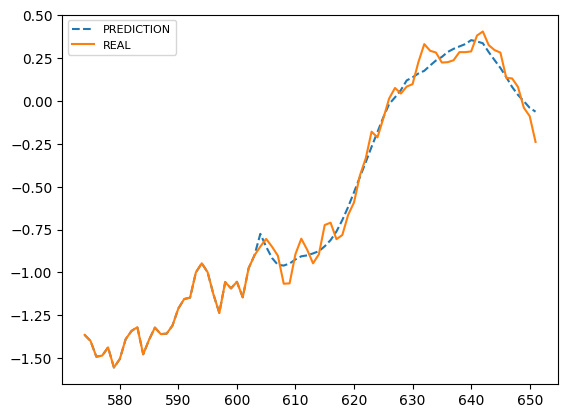

In [10]:
#prediction +plot#
res = model.predict(dataset_test)

df_final['pred'] = df_final['energie_ma']
for i in range(48):
    df_final['pred'][begin_date+i] = res[i]

if begin_date >= 1675:
    plt.plot(df_final['pred'][begin_date-100:begin_date],label='REAL');
    plt.plot(df_final['pred'][begin_date-1:begin_date+48],ls='--',label='PREDICTION');
else:
    plt.plot(df_final['pred'][begin_date-30:begin_date+48],ls='--',label='PREDICTION');
    plt.plot(df_final['energie_ma'][begin_date-30:begin_date+48],label='REAL');
    plt.legend(loc='upper left', fontsize=8);

df_final.index 

In [11]:
model

In [13]:
model.save('my_model')


INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [15]:
from tensorflow.keras.models import load_model

new_model = load_model('my_model')

In [21]:
y_train.shape

(48,)

In [25]:
y_train
np.ones(48)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [26]:
dataset_test = timeseries_dataset_from_array(
    X_train,
    np.ones(48),    
    sequence_length=50,
    batch_size=32,
)

2/2 [==============================] - 0s 11ms/step


RangeIndex(start=0, stop=1789, step=1)

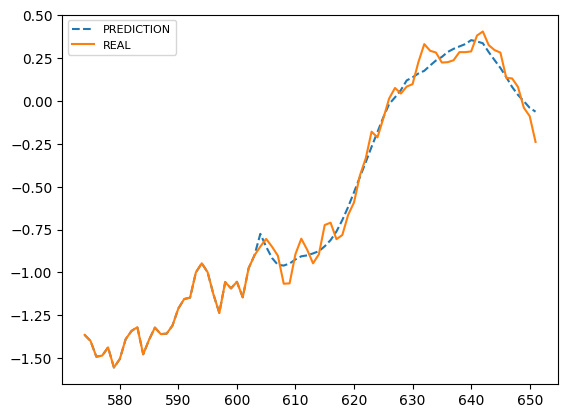

In [27]:
#prediction +plot#
res = new_model.predict(dataset_test)

df_final['pred'] = df_final['energie_ma']
for i in range(48):
    df_final['pred'][begin_date+i] = res[i]

if begin_date >= 1675:
    plt.plot(df_final['pred'][begin_date-100:begin_date],label='REAL');
    plt.plot(df_final['pred'][begin_date-1:begin_date+48],ls='--',label='PREDICTION');
else:
    plt.plot(df_final['pred'][begin_date-30:begin_date+48],ls='--',label='PREDICTION');
    plt.plot(df_final['energie_ma'][begin_date-30:begin_date+48],label='REAL');
    plt.legend(loc='upper left', fontsize=8);

df_final.index 

In [41]:
import requests

url = "http://127.0.0.1:8000/predict/"
file = {"file": X_train}

response =requests.post(url,files=file).json()
pred = np.array(response["pred"])
pred

array([[-0.77486461],
       [-0.85022843],
       [-0.91549128],
       [-0.95558357],
       [-0.95955825],
       [-0.94767255],
       [-0.92379725],
       [-0.90556979],
       [-0.90028447],
       [-0.8888889 ],
       [-0.87574011],
       [-0.8472321 ],
       [-0.81112128],
       [-0.76096916],
       [-0.69454098],
       [-0.61759365],
       [-0.53216839],
       [-0.44411433],
       [-0.35737687],
       [-0.26736492],
       [-0.18174551],
       [-0.09577891],
       [-0.01802032],
       [ 0.02095889],
       [ 0.06320189],
       [ 0.11951031],
       [ 0.1377198 ],
       [ 0.15998642],
       [ 0.17558928],
       [ 0.20669   ],
       [ 0.23580885],
       [ 0.25654036],
       [ 0.28541166],
       [ 0.30352098],
       [ 0.31770253],
       [ 0.33115894],
       [ 0.35419202],
       [ 0.34680462],
       [ 0.33606547],
       [ 0.28469199],
       [ 0.23789446],
       [ 0.19208916],
       [ 0.13881604],
       [ 0.0812723 ],
       [ 0.03494963],
       [-0